# Computer Vision Assignment 1 Part 1
---

Semester: **Fall 2023**

Due date: **October 5th 2023, 11.59PM EST.**

## Introduction
---

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used:
- MNIST (handwritten digits)
- CIFAR-10 (32x32 resolution color images of 10 object classes)

## Instructions
---

You should perform this assignment using Google Colab.
* Before starting, clone this assignment using `File > Save a copy in Drive`.
* After you're done, go through the notebook and ensure that you have answered all questions.
* Finally, submit the ipynb `File > Download > Download .ipynb` on brightspace


## 1. Warmup [5%]
---

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand. MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. On the other hand, CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). The train/test split is 50k/10k.

* (a) Display 10 random images from each class of MNIST
* (b) Do the same for each class of CIFAR-10

Use `matplotlib` and ipython notebook's visualization capabilities. See [this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) for hints on how to achieve this.

## 2. Training a Single Layer Network on MNIST [10%]
---

* (a) Start by running the training on MNIST and train the model for 20 epochs.
By default, the model will train on MNIST.

This will initialize a single layer model and train it on the 60,000 MNIST training images for 1 epoch (passes through the training data). The loss function ([cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy)) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`. The default values for the learning rate, batch size and number of epochs are given in the `options` cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. Note the decrease in training loss and corresponding decrease in validation errors.

* (b): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

* (c): Reduce the number of training examples to just 50. (Hint: limit the iterator in the `train` function) and train the model until the loss converges. Explain what is happening to the model.

## 3. Training a Multi-Layer Network on MNIST [10%]
---

* (a) Add an extra layer with 1000 hidden units and a `tanh` nonlinearity. (Hint: modify the `Net` class). Train the model for 10 epochs.
* (b) Now set the learning rate to 10 and observe what happens during training. Give a brief explanation of your observations

## 4. Training a Convolutional Network on CIFAR [25%]
---

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- (a) Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

* (b) Train it for 20 epochs on the CIFAR-10 training set. Show an image of the first layer filters.

* (c) Give a breakdown of the parameters within the above model, and the overall number.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist). Also, you may speed up training if you use a GPU runtime (`RunTime > Change Runtime Type > GPU`).

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Options
dataset = 'cifar10' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 20       # number of epochs to train
lr = 0.01        # learning rate

In [7]:
# Data Loading
# This cell might take some time when you run it for the first time,
# because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
num_classes = 10

def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  # npimg = img.numpy()
  img = torch.clamp(img, 0, 1)
  fig, ax = plt.subplots()
  ax.imshow(np.transpose(img, (1, 2, 0)))
  ax.set_facecolor('white')  # Set the background color of the figure to white
  ax.axis('off')
  plt.show()

def imshow_cov(img):
  # img = img / 2 + 0.5     # unnormalize
  # npimg = img.numpy()
  # img = torch.clamp(img, 0, 1)
  fig, ax = plt.subplots(figsize = (9,3))
  ax.imshow(np.transpose(img, (1, 2, 0)), cmap = 'Greys_r')
  ax.set_facecolor('white')  # Set the background color of the figure to white
  ax.axis('off')
  plt.show()

# get some random training images
class_examples = {i: [] for i in range(num_classes)}

for img, label in trainset:
    if len(class_examples[label]) < 100:
        class_examples[label].append(img)
    if all(len(class_examples[i]) == 100 for i in class_examples):
        break

In [ ]:
for i in class_examples.keys():
    print(f'\bClass: {trainset.classes[i]}')
    imshow(torchvision.utils.make_grid(class_examples[i],))

#### whitening

In [5]:
N, H, W, C = trainset.data.shape
dd = trainset.data.reshape(N, -1)
dd = torch.from_numpy(dd).to(torch.float64)

img_centered = dd - dd.mean(dim = 0, keepdim = True)

cov_mat = torch.matmul(img_centered.permute(1, 0), img_centered)
eps = 1e-9
n_comp = 400
eigval, eigv =  torch.linalg.eigh(cov_mat)
eigval_, eigv_ = eigval[eigval.argsort(descending=True)[:n_comp]], eigv.T[eigval.argsort(descending=True)[:n_comp]].T

W_hat = eigv_ @ torch.diag(1/torch.sqrt(eigval_)) @ eigv_.T

Y = img_centered @ W_hat * np.sqrt(N-1) 
Y_shift = Y * 64 + 128

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   
plt.rcParams['image.cmap'] = 'gray'

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

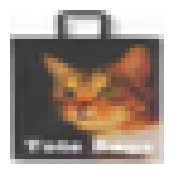

In [8]:
dd = np.vstack(tuple(unpickle("cifar-10-batches-py/data_batch_{}".format(n))[b'data'] for n in range(1,6)))

red_cat_bag = dd[3000].reshape(3,32,32).transpose([1,2,0])
fig, ax = plt.subplots(figsize = (2,2))
ax.imshow(red_cat_bag)
ax.axis('off')
plt.show()

In [9]:
_, H, W, C = trainset.data.shape
N = dd.shape[0]
mean_ = dd.mean(0)[None, :]
dd_centered = dd - mean_

cov_mat  = (dd_centered.T @ dd_centered)
eps = 1e-9
n_comp = 400
eigval, eigv =  np.linalg.eigh(cov_mat)
eigval_, eigv_ = eigval[eigval.argsort()[::-1]][:n_comp], eigv.T[eigval.argsort()[::-1][:n_comp]].T

W_hat = eigv_/np.sqrt(eigval_[None, :]) @ eigv_.T
y = dd_centered[3000] @ W_hat * np.sqrt(N-1)  *64 + 128

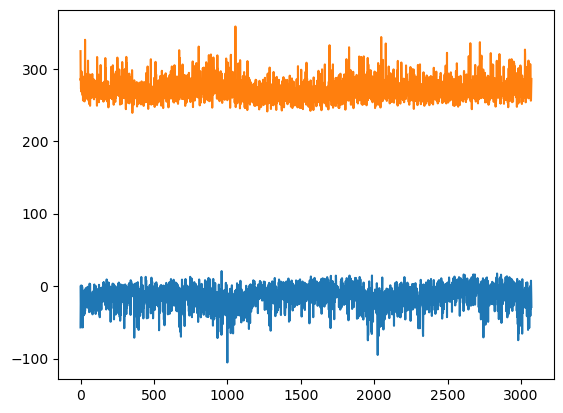

In [13]:
y_ = dd_centered @ W_hat* np.sqrt(N-1) * 64 + 128
plt.plot(y_.min(0))
plt.plot(y_.max(0))

(-0.5, 31.5, 31.5, -0.5)

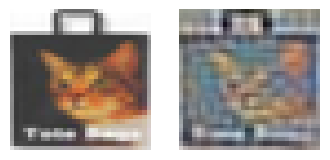

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=400, random_state=0, svd_solver='randomized')
pca.fit(dd)

def whiten(pca, vec):
    QQ = np.dot(vec - pca.mean_, pca.components_.T)
    return np.dot(QQ / pca.singular_values_, pca.components_) * np.sqrt(60000) * 64 + 128

def vtoimg(v):
     return np.array(np.clip(v, 0, 255), dtype=np.uint8).reshape(3,32,32).transpose([1,2,0])

# whitened_cat = vtoimg(whiten(pca, dd[3000]))

fig, ax = plt.subplots(1,2, figsize = (4,2))
ax[0].imshow(red_cat_bag)
ax[0].axis('off')
ax[1].imshow(vtoimg(y_[3000]))
ax[1].axis('off')

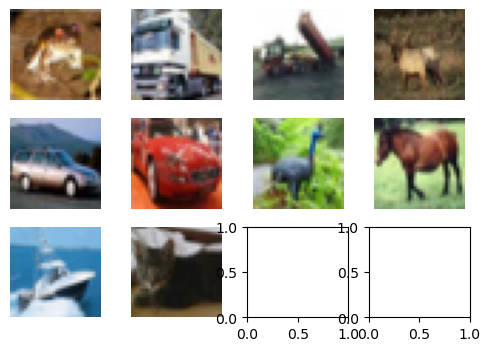

In [15]:
fig, ax = plt.subplots(3, 4, figsize = (6, 4))
for i in range(10):
    ax[i//4][i%4].imshow(dd[i].reshape(C, H, W).transpose(1, 2, 0))
    ax[i//4][i%4].axis('off')

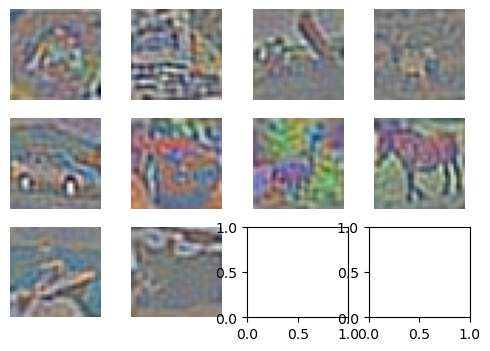

In [16]:
fig, ax = plt.subplots(3, 4, figsize = (6, 4))
for i in range(10):
    whitened = dd_centered[i] @ W_hat * np.sqrt(N-1) *64 + 128
    whitened = vtoimg(whitened)
    ax[i//4][i%4].imshow(whitened)
    ax[i//4][i%4].axis('off')

In [5]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
num_hidden = num_inputs
class Net(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(Net, self).__init__()
        self.i2h = nn.Linear(num_inputs, num_hidden)
        self.h2o = nn.Linear(num_hidden, num_outputs)
        self.tanh = nn.Tanh()


    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        # hidden = self.i2h(input)
        # hidden = self.tanh(hidden)
        # output = self.h2o(hidden)
        output = self.h2o(input)
        return output

network = Net(num_inputs, num_hidden, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

#### DeepDream

In [4]:
model = 

|

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/tiny-imagenet-train



|

hub://activeloop/tiny-imagenet-train loaded successfully.



Dataset(path='hub://activeloop/tiny-imagenet-train', read_only=True, tensors=['bbox', 'image', 'label'])

In [14]:
ds

Dataset(path='hub://activeloop/tiny-imagenet-train', read_only=True, tensors=['bbox', 'image', 'label'])

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
out = model(img.unsqueeze(0))
out

In [6]:
iters = 3
img_list = []

for iter in range(iters):
    out = model(img)
    loss= nn.MSELoss(out, label)

torch.Size([3, 224, 224])

In [13]:
def train(epoch):
    network.train()
    for i in range(1, epoch + 1):
    #   total_loss = 0
      for batch_idx, (data, target) in enumerate(train_loader):
          optimizer.zero_grad()
          output = network(data)
          loss = F.cross_entropy(output, target)
        #   total_loss += loss.detach().cpu().item()
          loss.backward()
          optimizer.step()
          # if batch_idx >= 50:
          #   break
    #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
    #         i+1, batch_idx, len(train_loader),
    #         100. * batch_idx / len(train_loader), total_loss/len(train_loader)))

          if batch_idx % 100 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  i+1, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.item()))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [7]:
network = Net(num_inputs, num_hidden, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)
# train(20)

# torch.save(network.state_dict(), f'{dataset}_model.pth')

network.load_state_dict(torch.load(f'{dataset}_model.pth'))

<All keys matched successfully>

In [8]:
test()


Test set: Average loss: 0.2713, Accuracy: 9242/10000 (92%)



### 2(b)

In [11]:
# import visdom

# vis = visdom.Visdom()
# weights = network.h2o.weight.data.view(-1, 28, 28).numpy()
# for i in range(num_classes):
#     vis.heatmap(weights[i], opts=dict(title=f'{trainset.classes[i]}'))
    

Setting up a new session...


In [15]:
num_inputs = 3
num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
hidden_size = [16, 128]
fc_size = [128*5*5, 64]
class enhanced_net(nn.Module):
    def __init__(self, num_inputs, hidden_size, fc_size, num_outputs):
        super(enhanced_net, self).__init__() 
        modules = []
        for i in hidden_size:
            modules.append(nn.Conv2d(num_inputs, i, kernel_size=5,))
            modules.append(nn.Tanh())
            modules.append(nn.MaxPool2d(2, padding = 0))
            num_inputs = i
        self.conv = nn.Sequential(*modules)
        self.fc = nn.Sequential(nn.Linear(fc_size[-2], fc_size[-1]),
                                nn.Tanh(),
                                nn.Linear(fc_size[-1], num_outputs))



    def forward(self, input):
        out = self.conv(input)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out

In [16]:
network = enhanced_net(num_inputs = num_inputs, hidden_size = hidden_size, fc_size= fc_size, num_outputs = num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [ ]:
train(20)

torch.save(network.state_dict(), f'{dataset}_model_20.pth')
network.load_state_dict(torch.load(f'{dataset}_model_20.pth'))

In [18]:
test()


Test set: Average loss: 0.9351, Accuracy: 6721/10000 (67%)



In [19]:
total_params = 0
for name, param in network.named_parameters():
    if param.requires_grad:
        layer_params = param.numel()
        total_params += layer_params
        print(f"{name:<20} {layer_params:<20}")

print(f"total params\t\t{total_params:<20}")

conv.0.weight        1200                
conv.0.bias          16                  
conv.3.weight        51200               
conv.3.bias          128                 
fc.0.weight          204800              
fc.0.bias            64                  
fc.2.weight          640                 
fc.2.bias            10                  
total params		258058              


In [25]:
from torchinfo import summary
summary(network, input_size=(32, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
enhanced_net                             [32, 10]                  --
├─Sequential: 1-1                        [32, 128, 5, 5]           --
│    └─Conv2d: 2-1                       [32, 16, 28, 28]          1,216
│    └─Tanh: 2-2                         [32, 16, 28, 28]          --
│    └─MaxPool2d: 2-3                    [32, 16, 14, 14]          --
│    └─Conv2d: 2-4                       [32, 128, 10, 10]         51,328
│    └─Tanh: 2-5                         [32, 128, 10, 10]         --
│    └─MaxPool2d: 2-6                    [32, 128, 5, 5]           --
├─Sequential: 1-2                        [32, 10]                  --
│    └─Linear: 2-7                       [32, 64]                  204,864
│    └─Tanh: 2-8                         [32, 64]                  --
│    └─Linear: 2-9                       [32, 10]                  650
Total params: 258,058
Trainable params: 258,058
Non-trainable params: 0


In [42]:
first_conv_layer = network.conv[0]  # Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
first_conv_weights = first_conv_layer.weight.data.cpu()  # Shape: [16, 3, 5, 5]


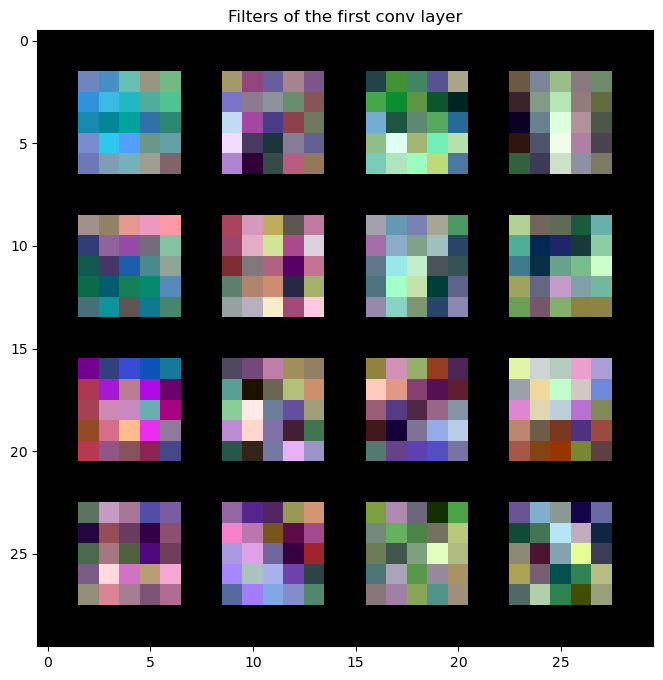

In [43]:
# Visualize using torchvision's make_grid
plt.figure(figsize=(8, 8))
grid = torchvision.utils.make_grid(first_conv_weights, nrow=4, normalize=True, scale_each=True)
plt.imshow(grid.permute(1, 2, 0))  # Change the order of dimensions to (H, W, C) for display
plt.title("Filters of the first conv layer")
plt.show()

In [72]:
axes

<Axes: >